# 주제 : 추천 시스템 - 영화 데이터셋과 Embedding & Ranking 알고리즘으로 추천시스템 만들기
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.
    
    
## 데이터 소개
    - 이번 주제도 마찬가지로 MovieLens Dataset을 사용합니다.
    - 같은 데이터라도 상황과 데이터의 크기에 따라 다양한 추천 방법을 활용할 수 있어야 합니다.
    - 파일은 세 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    3. users.dat
    user_id : 사용자 아이디
    gender : 사용자 성별
    age : 사용자 나이
    occupation : 사용자 직업코드
    zipcode : 사용자 거주코드

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - Large-Scale 에서 적용 가능한 추천시스템 구조 이해
    - Word2Vec 기반의 임베딩 모델 이해
    - EDA로 수행할 수 있는 다양한 인사이트 활용
    - Point-wise 모델링에 대한 이해
    - Factorization Machine 알고리즘에 대한 이해
    - ML에 활용할 수 있는 데이터 변환 능력 습득
    - 모델의 추천 결과를 평가하는 방법에 대한 연습

- 출제자 : 윤기태 강사
---

## Step 1. Word2Vec 알고리즘 기반 추천 후보군 생성

#### Rating Matrix 기반 추천시스템의 한계

    [Memory Based Recommendations]
    1. 만약 유저, 영화의 수가 3000이 아니라 3천만 개 라면?
    2. Matrix의 크기는 30,000,000 X 30,000,000
    3. 연산량 자체도 문제가 되지만, Extreme Sparse 벡터가 되면서 정확도 역시 현저하게 떨어지게 됨
    4. 차원축소, ALS 등의 방법으로 어느정도 극복할 수 있지만, 근본적인 해결책이 되지는 못함

- Recommendation in Large Scale System
  - Architecture
  ![recsys_architecture](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F30pCp%2Fbtqv7PV6365%2FCkl5dwvSoQF3RdneCIzGr1%2Fimg.png)
  - 데이터 수집과 처리 단계를 제외하면, 추천시스템은 다음과 같은 레이어로 구분되는 추세
    - `Generate Candidates` : 수백, 수천만개의 Item 중, 후보가 될 만한 Item을 추출. 여기에 CF 등의 방법을 사용할 수도 있지만, 일반적으로는 연산량이 작은 여러 개의 전략(시나리오)들을 합쳐서 coverage 자체를 확보하는 역할을 함. 예를 들면 인기도가 높은 Item, 연관성이 높은 Item 등을 별개의 전략으로 추출하는 것.
    - `Intention Predict` : User의 Context에 기반하여 Candidates를 한 번 더 좁혀주는 역할. 반드시 필요한 단계는 아니며, Candidates를 추렸음에도 여전히 Large Scale 문제를 가지고 있는 경우에 필터링의 역할로 사용할 수 있음.
    - `Personalized Ranking` : 일반적으로 추천시스템에서 추천이 잘 되었는지를 평가하는 지표는 CTR, CVR 같은 지표. 이 지표들을 Maximize 할 수 있는 방법으로 개인화 모델을 학습. 일반적인 Classifier를 생각해도 무방하며, 학습 데이터셋을 잘 구축하는 것이 좋은 추천 랭킹모델을 만드는 것.

![recsys_architecture2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FUsbKo%2Fbtqv7PBN46z%2Fd4m5pf7lrKs1CqxzkROY81%2Fimg.png)


-----

#### Word2Vec 기반의 Movie2Vec 만들기

    [Word2Vec]
    1. 임베딩(Embedding) 방법론 중 가장 대중적이고 성능이 좋은 방법
    2. 같은 문장 내, 혹은 비슷한 위치에 등장하는 단어들은 유사한 의미를 가지고 있을 것이라는 가정.
    3. 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음
    4. Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.
      - 예시 문장 : "역시 성공은 고난을 동반 말없이 등산을 등반하는 것처럼"
      - 만약 "성공"이라는 단어를 중심 단어로 활용한다면, [역시, _, 고난을, 동반] 이러한 주변 단어를 가지고 중심에 있는 단어의 벡터를 학습할 수 있게 됨. (Skip-gram 방식. CBOW는 반대)

![skipgram](http://i.imgur.com/TupGxMl.png)

    [학습 원리]
    1. 단어셋의 크기를 dim으로 하는 input/output 벡터를 활용하여 softmax classification
    2. 따라서 아래 함수를 최소화 하는 것을 목표로 하는 network를 학습하게 됨

![function](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/function.png)

    [벡터 표현]
    1. 학습된 네트워크의 hidden layer (projection layer)에 단어의 벡터가 표현됨
    2. 이를 lookup 이라고 함

![lookup](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/lookup.png)

-----

    [영화의 벡터 표현]
    1. word2vec 방법에서 word를 item으로 치환하면, item2vec으로 활용할 수 있음 (많은 추천시스템에서 활용하는 방법)
    2. 단, 이 방법은 데이터의 meta-data가 하나의 축으로 이루어진 단어에서와 달리, 영화처럼 multi-axis meta-data를 가진 데이터에서는 완전한 표현이라고 볼 수 없음 (ex. 장르, 감독 등등의 정보)
    3. 또한 item2vec 메커니즘을 추천시스템에 활용하면 필연적으로 cold-start 문제가 발생할 수 있음
    4. `Cold-start Problem` : 새로운 유저나 새로운 아이템을 대상으로 추천하게 될 때, 기존 학습모델에서는 등장한 적 없는 데이터이기 때문에 추천 대상으로 포함되기 어려운 현상
    5. 임베딩 기반 추천에서 cold-start를 극복하는 방법은 여러가지가 있지만, 그 중에서 가장 적용하기 간단하면서도 중요한 개념을 담고 있는 meta-prod2vec을 활용
    6. 자세한 내용 : https://arxiv.org/pdf/1607.07326.pdf

![meta-prod2vec](https://image.slidesharecdn.com/metaprod2vec-161007133531/95/metaprod2vec-simple-product-embeddings-with-sideinformation-36-638.jpg?cb=1475847427)

### 문제 1. 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

In [3]:
print('Rating')
display(rating_df.head(2))
print('Movie')
display(movie_df.head(2))
print('User')
display(user_df.head(2))

Rating


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109


Movie


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


User


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072


### 문제 2. EDA & 전처리 - 사용자별 시청 목록 추출

In [4]:
# groupby, apply 함수로 사용자별 시청 목록 추출 
def get_movie_list_sort_vy_time(x):
    return x.sort_values(['time'])['movie_id'].tolist()

user_watch_list = rating_df.groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_vy_time(x))
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

영화 개수 : 3706


<AxesSubplot:>

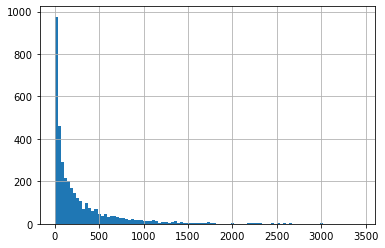

In [5]:
print(f'영화 개수 : {rating_df["movie_id"].nunique()}')

rating_df['movie_id'].value_counts().hist(bins=100)

### 문제 3. EDA & 전처리 - 영화 개봉년도 피쳐 생성

In [6]:
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# title 피처에서 개봉 년도 (ex. 1990, 2000...) 분리

movie_df['released_year_area'] = movie_df['title'].apply(lambda x: int(x[-5:].split(')')[0]))
movie_df.head(3)

,movie_id,title,genre,released_year_area
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


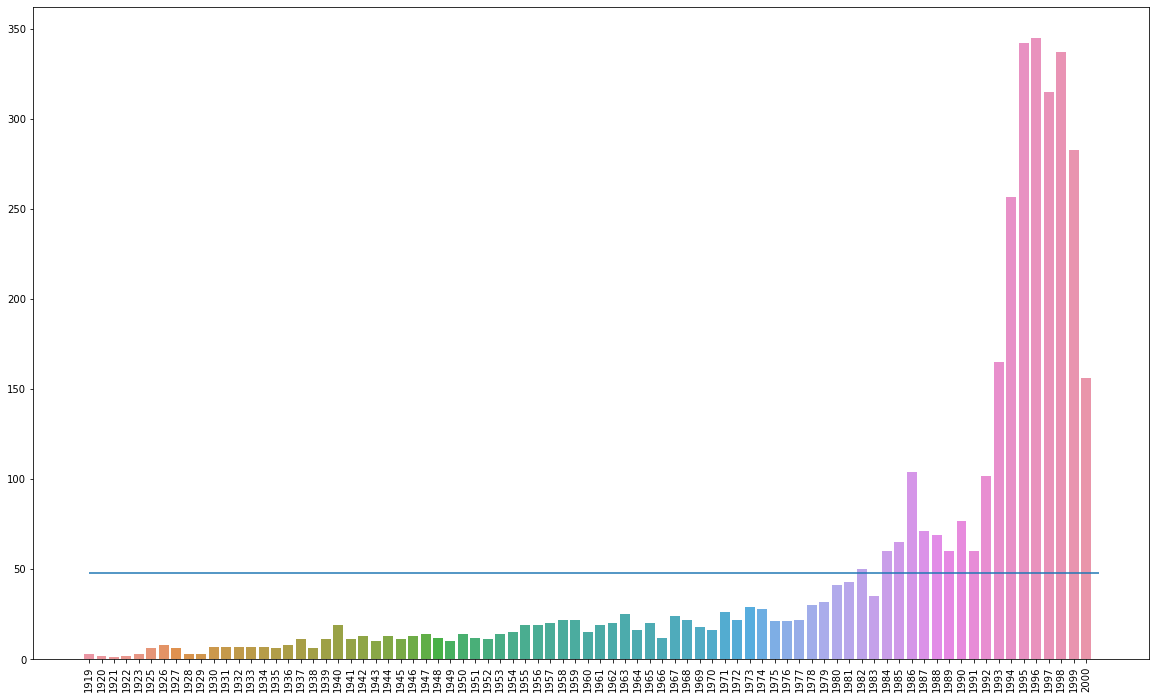

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.barplot으로 개봉 년도별 영화 갯수 시각화
released_year_area = movie_df['released_year_area'].value_counts().sort_index()

plt.figure(figsize=(20, 12))
sns.barplot(x=released_year_area.index, y=released_year_area.values)
plt.xticks(rotation=90)
plt.hlines(y=released_year_area.mean(), xmin=0, xmax=len(released_year_area))
plt.show()

### 문제 4. EDA & 전처리 - 영화 장르 피쳐 생성

<AxesSubplot:>

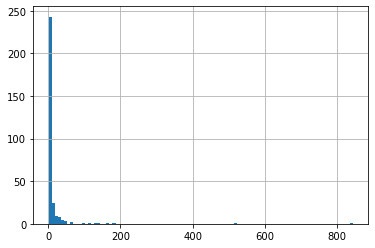

In [9]:
movie_df['genre'].value_counts().hist(bins=100) # 대부분이 장르가 1개

In [10]:
# genre 피처에서 영화의 대표 장르 추출
movie_df['main_genre'] = movie_df['genre'].map(lambda x: x.split('|')[0])
print(movie_df['main_genre'].value_counts())

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Musical          25
Film-Noir        25
War              12
Fantasy           2
Name: main_genre, dtype: int64


### 문제 5. Embedding - EDA 결과를 활용하여 Movie2Vec 학습

In [11]:
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1995,Comedy


In [12]:
# movie_meta_dict 생성

# ex.
# {'main_genre': {1: 'Animation',
#   2: 'Adventure',
#   3: 'Comedy',
#   4: 'Comedy',
#   5: 'Comedy',
#   ...
#   'released_year_area': {...},
#   ...
# }

movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()

In [13]:
# Gensim을 활용한 meta-prod2vec을 학습할 수 있는 데이터셋 생성

# ex. [['movie_id:3186', 'year:1990', 'genre:Drama', 'movie_id:1721', 
#       'year:1990', 'genre:Drama', 'movie_id:1022', 'year:1950', 
#       'genre:Animation', 'movie_id:1270', 'year:1980', 'genre:Comedy', 'movie_id:2340'...]]
movie2vec_dataset = []
for movie_list in user_watch_list:
    meta_list = []
    for movie_id in movie_list:
        word_meta_1 = 'movie_id:' + str(movie_id)
        word_meta_2 = 'year:' + str(movie_meta_dict['released_year_area'][movie_id])
        word_meta_3 = 'genre:' + str(movie_meta_dict['main_genre'][movie_id])
        meta_list.append(word_meta_1)
        meta_list.append(word_meta_2)
        meta_list.append(word_meta_3)
    movie2vec_dataset.append(meta_list)

In [ ]:
# from gensim.models import Word2Vec

# model = Word2Vec(movie2vec_dataset,
#                  size=100,
#                  window=6,  # 주변 word의 윈도우
#                  sg=1,  # skip-gram OR cbow
#                  hs=0,  # hierarchical softmax OR negative sampling
#                  negative=20,  # negative sampling 파라미터
#                  min_count=1,  # word의 등장 최소 횟수
#                  iter=20)

In [14]:
max_leng = 0
for i in movie2vec_dataset:a
    if len(i) > max_leng:
        max_leng = len(i)
    else:
        continue
        
print(max_leng)

6942


In [15]:
# !pip install gensim

In [91]:
movie2vec_dataset[0]

['movie_id:3186',
 'year:1999',
 'genre:Drama',
 'movie_id:1721',
 'year:1997',
 'genre:Drama',
 'movie_id:1022',
 'year:1950',
 'genre:Animation',
 'movie_id:1270',
 'year:1985',
 'genre:Comedy',
 'movie_id:2340',
 'year:1998',
 'genre:Romance',
 'movie_id:1836',
 'year:1998',
 'genre:Drama',
 'movie_id:3408',
 'year:2000',
 'genre:Drama',
 'movie_id:1207',
 'year:1962',
 'genre:Drama',
 'movie_id:2804',
 'year:1983',
 'genre:Comedy',
 'movie_id:720',
 'year:1996',
 'genre:Animation',
 'movie_id:1193',
 'year:1975',
 'genre:Drama',
 'movie_id:260',
 'year:1977',
 'genre:Action',
 'movie_id:919',
 'year:1939',
 'genre:Adventure',
 'movie_id:608',
 'year:1996',
 'genre:Crime',
 'movie_id:2692',
 'year:1998',
 'genre:Action',
 'movie_id:1961',
 'year:1988',
 'genre:Drama',
 'movie_id:2028',
 'year:1998',
 'genre:Action',
 'movie_id:3105',
 'year:1990',
 'genre:Drama',
 'movie_id:938',
 'year:1958',
 'genre:Musical',
 'movie_id:1962',
 'year:1989',
 'genre:Drama',
 'movie_id:1035',
 'year

In [17]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 vector_size=100, 
                 window=7,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 epochs=20)

In [18]:
model.save('movie2vec_model')

### 문제 6. Embedding - 일부 데이터로 Movie2Vec 학습 결과 확인

In [19]:
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1995,Comedy


In [20]:
# most_similar 함수로 학습 결과 확인
display(model.wv.most_similar('movie_id:3186', topn=5))

def similar_movie_title(x):
    movie_titles = []
    movie_similarities = []
    for i in x:
        movie_idx = int(i[0].split(':')[1])
        movie_title = movie_df.loc[movie_df['movie_id'] == movie_idx, 'title'].values
        movie_titles.append(movie_title[0])
        movie_similarities.append(i[1])
        df = pd.DataFrame({'Title' : movie_titles, 'Similarity' : movie_similarities})
        
    return df
    

similar_movie_title(model.wv.most_similar('movie_id:3186', topn=5))

[('movie_id:3125', 0.8196754455566406),
 ('movie_id:3145', 0.8140808343887329),
 ('movie_id:3078', 0.7281928658485413),
 ('movie_id:3147', 0.7254190444946289),
 ('movie_id:2889', 0.7143061757087708)]

,Title,Similarity
0,"End of the Affair, The (1999)",0.819675
1,"Cradle Will Rock, The (1999)",0.814081
2,Liberty Heights (1999),0.728193
3,"Green Mile, The (1999)",0.725419
4,"Mystery, Alaska (1999)",0.714306


In [21]:
similar_movie_title(model.wv.most_similar('movie_id:1', topn=5))

,Title,Similarity
0,"Grand Day Out, A (1992)",0.791891
1,"Close Shave, A (1995)",0.732300
2,Babe (1995),0.727030
3,Toy Story 2 (1999),0.722694
4,Creature Comforts (1990),0.691877


In [22]:
display(movie_df[movie_df['movie_id'] == 1])
display(movie_df[movie_df['movie_id'].isin([1223, 3114, 745, 34, 1148])])

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation


,movie_id,title,genre,released_year_area,main_genre
33,34,Babe (1995),Children's|Comedy|Drama,1995,Children's
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,1995,Animation
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy,1993,Animation
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1992,Animation
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999,Animation


In [23]:
display(movie_df[movie_df['movie_id'] == 1])
display(movie_df[movie_df['movie_id'].isin([1223, 3114, 745, 34, 1148])])

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation


,movie_id,title,genre,released_year_area,main_genre
33,34,Babe (1995),Children's|Comedy|Drama,1995,Children's
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,1995,Animation
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy,1993,Animation
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1992,Animation
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999,Animation


In [24]:
model.wv.most_similar('genre:Drama')

[('movie_id:2218', 0.5939661860466003),
 ('movie_id:381', 0.5925782322883606),
 ('movie_id:515', 0.5840121507644653),
 ('movie_id:523', 0.5766736268997192),
 ('movie_id:90', 0.5765171051025391),
 ('movie_id:650', 0.5731550455093384),
 ('movie_id:1709', 0.5687155723571777),
 ('movie_id:2501', 0.5680491924285889),
 ('movie_id:448', 0.5680034756660461),
 ('movie_id:1139', 0.566596269607544)]

### 문제 7. EDA & 전처리 - Movie2Vec 모델로 Item2Item 후보군 생성

In [25]:
movie_df['movie_id']

0          1
1          2
2          3
3          4
4          5
        ... 
3878    3948
3879    3949
3880    3950
3881    3951
3882    3952
Name: movie_id, Length: 3883, dtype: int64

In [26]:
# item to item 후보군 생성할 변수
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0

for movie_id in movie_df['movie_id'].values:
    item2item[movie_id] = []
    try :
        sim_list = model.wv.most_similar('movie_id:' + str(movie_id), topn=k+10)
        for movie_tup in sim_list:
            tup_info = movie_tup[0].split(':')
            if (tup_info[0] == 'movie_id') and (len(item2item) < 10):
                item2item[movie_id].append(tup_info[1])
    except:
        not_in_count +=1
        print('word', str(movie_id), 'not in vocabulary')

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [27]:
item2item[1]

['1223',
 '745',
 '34',
 '3114',
 '3429',
 '1265',
 '1148',
 '176',
 '2324',
 '1537',
 '1136',
 '2700',
 '2289',
 '720',
 '2321',
 '1923',
 '1394',
 '50',
 '235',
 '2359']

## Step 2. 탐색적으로 다양한 추천 후보군 생성

### 문제 8. EDA & 전처리 - 평균 평점 기반 Popular 후보군 생성

In [28]:
## 인기도에 따른 movie 추천
# 일정 count 이상이면서 평균 rating이 높은 순서대로 Popular 후보군 생성 (movie_id에 groupby 적용)

mean_ratings = rating_df.groupby('movie_id')['rating'].agg(['mean', 'count'])
mean_ratings

,mean,count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296
...,...,...
3948,3.635731,862
3949,4.115132,304
3950,3.666667,54


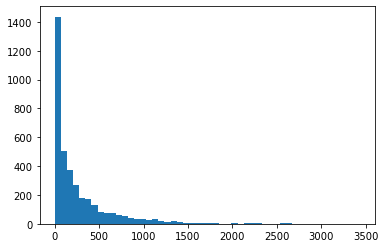

In [29]:
plt.hist(mean_ratings['count'], bins=50)
plt.show()

### 문제 9. EDA & 전처리 - Popular 후보군 생성 결과 확인

In [30]:
# 생성 결과를 popular_movie_list 변수에 할당
# 10번 이상 rating있는 것들

popular_movie_list = mean_ratings[mean_ratings['count'] >10]['mean'].sort_values(ascending=False)[:15].tolist()
popular_movie_list

[4.608695652173913,
 4.560509554140127,
 4.554557700942973,
 4.524966261808367,
 4.52054794520548,
 4.517106001121705,
 4.510416666666667,
 4.507936507936508,
 4.491489361702127,
 4.477724741447892,
 4.476190476190476,
 4.473913043478261,
 4.453694416583082,
 4.452083333333333,
 4.4498902706656915]

### 문제 10. EDA & 전처리 - 장르 & 연도 기준 Meta2Item 후보군 생성

In [31]:
merge_df = pd.merge(mean_ratings, movie_df, on='movie_id')
merge_df.head(3)

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy


In [32]:
# 장르 & 연도를 meta로 하는, meta별 상위 10개씩 popular list 추출

def get_meta_popular_list(k, x):
    movie_id_list = x.sort_values(by='mean', ascending=False)['movie_id'].tolist()
    return movie_id_list[:k]
    

genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x=x, k=10))
year_popular = merge_df.groupby('released_year_area').apply(lambda x: get_meta_popular_list(x=x, k=10))

print(genre_popular[:5])
print()
print(year_popular[:5])

main_genre
Action        [2905, 2019, 858, 1198, 260, 1221, 2028, 2571,...
Adventure     [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259...
Animation     [745, 1148, 720, 1223, 3429, 3114, 1, 741, 276...
Children's    [1097, 1028, 34, 262, 3396, 755, 531, 3397, 55...
Comedy        [1830, 3233, 3607, 3030, 3307, 3022, 1136, 341...
dtype: object

released_year_area
1919    [3132, 2821, 2823]
1920                [3309]
1921                [3310]
1922                [1348]
1923          [3140, 3641]
dtype: object


### 문제 11. EDA & 전처리 - Meta 후보군 생성 결과 확인

In [33]:
# 위 결과 확인
# ex.
# 연도별 popular list - {'1910': [3132, 2821, 2823], '1920': [3517, 3022, 3629, 2010], ....}

genre_popular_dict = genre_popular.to_dict()
year_popular_dict = year_popular.to_dict()

print(f"Action : {genre_popular_dict['Action']}")
print(f"2000 Year : {year_popular_dict[2000]}")

Action : [2905, 2019, 858, 1198, 260, 1221, 2028, 2571, 1197, 1233]
2000 Year : [3881, 3888, 3897, 3949, 3578, 3911, 3647, 3353, 3851, 3317]


## Step 3. Point-wise 데이터셋 생성

#### Ranking Model

    [랭킹 모델의 형태와 역할]
    1. Binary Classification을 학습하는 Regressor가 가장 대표적인 예
    2. y=1은 User가 Item을 시청(혹은 구매 등)한 경우 -> **Ground Truth**
    3. f(x_ui) = X_u + X_i + b -> **X_u는 User의 여러가지 정보를 벡터로 나타낸 것, 그리고 X_i는 아이템의 여러가지 정보를 벡터로 나타낸 것**
    4. NDCG, AUC, Top@Precision... 등을 기준으로 모델을 학습 (랭킹 학습 방식인 Point-wise, Pair-wise 등을 기준으로 각각 다름)

![point-wise](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/point-wise.png)

### 문제 12. EDA & 전처리 - 특정 시간 기준 데이터셋 분리

975768738.0


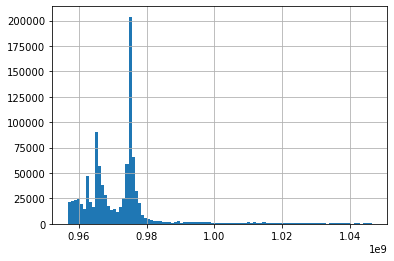

In [34]:
# 데이터셋을 8:2로 나눌 수 있는 시간을 기준으로 데이터셋을 train,test로 분리

q_8 = rating_df['time'].quantile(0.8)
print(q_8)
rating_df['time'].hist(bins=100)
plt.show()

In [35]:
train_df = rating_df[rating_df['time'] < q_8] 
test_df = rating_df[rating_df['time'] >= q_8]

print(f'Train DataFrame Shape : {train_df.shape}')
print(f'Test DataFrame Shape : {test_df.shape}')

Train DataFrame Shape : (800164, 4)
Test DataFrame Shape : (200045, 4)


### 문제 13. User Profiling - 유저 속성 EDA (gender, age, occupation, zipcode)

In [36]:
user_df.head(3)

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


##### 1) Gender

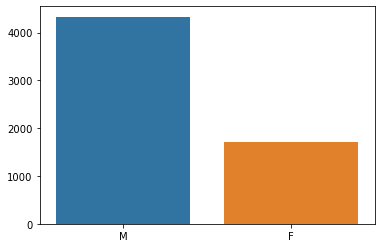

In [37]:
gender = user_df['gender'].value_counts()
sns.barplot(gender.index, gender.values)
plt.show()

#### 2) Age

<AxesSubplot:>

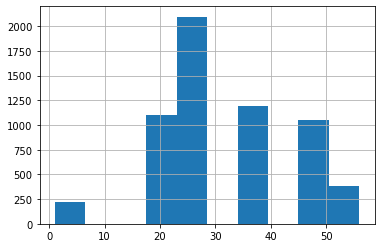

In [38]:
# age 피처 탐색
user_df.age.hist()

In [39]:
# age 피처 bucketize (구간별로 되어있는 것)
user_df['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [40]:
def age_bucket(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_df['age_bucket'] = user_df['age'].apply(age_bucket)
user_df['age_bucket'].value_counts()

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: age_bucket, dtype: int64

#### 3) Occupation

In [41]:
# occupation 피처 탐색

user_df['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

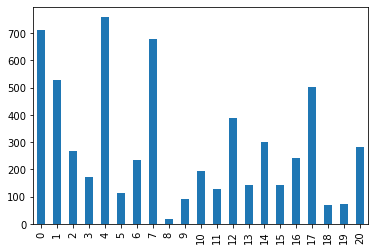

In [42]:
user_df['occupation'].value_counts().plot(kind='bar')
plt.show()

#### 4) Zipcode

In [43]:
# zipcode 피처 탐색
user_df['zipcode'].value_counts()

48104    19
22903    18
55104    17
94110    17
55455    16
         ..
77459     1
03756     1
76205     1
47274     1
02777     1
Name: zipcode, Length: 3439, dtype: int64

### 문제 14. User Profiling - 유저 속성별 피쳐맵 생성

In [44]:
user_df.head(2)

,user_id,gender,age,occupation,zipcode,age_bucket
0,1,F,1,10,48067,outlier
1,2,M,56,16,70072,50


#### 1) Gender

In [45]:
# gender 피처맵 생성 
gender_list = user_df['gender'].unique()
gender_index = {}

for idx, gender in enumerate(gender_list):
    gender_index[gender] = idx+1
    
    
gender_index
# ex.
# {'F': 1, 'M': 2}

{'F': 1, 'M': 2}

#### 2) Age

In [46]:
# age 피처맵 생성

age_list = user_df['age_bucket'].unique()
age_index = {}

for idx, age in enumerate(age_list):
    age_index[age] = idx+1

age_index
# ex.
# {'10': 6, '20': 3, '30': 5, '40': 4, '50': 2, 'outlier': 1}

{'outlier': 1, '50': 2, '20': 3, '40': 4, '30': 5, '10': 6}

#### 3) Occupation

In [47]:
# occupation 피처맵 생성
occupation_list = user_df['occupation'].unique()
occupation_index = {}

for idx, occ in enumerate(occupation_list):
    occupation_index[occ] = idx+1

occupation_index
# ex.
# {0: 10,
#  1: 7,
#  2: 17,
#  3: 11,
#  4: 13,
#  ...}

{10: 1,
 16: 2,
 15: 3,
 7: 4,
 20: 5,
 9: 6,
 1: 7,
 12: 8,
 17: 9,
 0: 10,
 3: 11,
 14: 12,
 4: 13,
 11: 14,
 8: 15,
 19: 16,
 2: 17,
 18: 18,
 5: 19,
 13: 20,
 6: 21}

### 문제 15. Item Profiling - 영화 속성별 피쳐맵 생성 (장르, 년도)

#### 1) Genre

In [48]:
# genre 피처맵 생성

genre_list = merge_df['main_genre'].unique()
genre_dict = {}

for i, g in enumerate(genre_list):
    genre_dict[g] = i + 1
genre_dict

# ex.
# {'Action': 4,
#  'Adventure': 2,
#  'Animation': 1,
#  "Children's": 9,
#  'Comedy': 3,
#  'Crime': 7,
#  'Documentary': 10,
#  'Drama': 5,
#  'Fantasy': 17,
#  'Film-Noir': 15,
#  'Horror': 12,
#  'Musical': 18,
#  'Mystery': 14,
#  'Romance': 8,
#  'Sci-Fi': 11,
#  'Thriller': 6,
#  'War': 16,
#  'Western': 13}

{'Animation': 1,
 'Adventure': 2,
 'Comedy': 3,
 'Action': 4,
 'Drama': 5,
 'Thriller': 6,
 'Crime': 7,
 'Romance': 8,
 "Children's": 9,
 'Documentary': 10,
 'Sci-Fi': 11,
 'Horror': 12,
 'Western': 13,
 'Mystery': 14,
 'Film-Noir': 15,
 'War': 16,
 'Fantasy': 17,
 'Musical': 18}

#### 2) Year

In [49]:
# year 피처맵 생성
year_list = merge_df['released_year_area'].unique()
year_dict = {}

for i, y in enumerate(year_list):
    year_dict[y] = i + 1

str(year_dict)[:30]


'{1995: 1, 1994: 2, 1996: 3, 19'

### 문제 16. Context Profiling - 특정 시간 기준 유저 행동 EDA (시청한 영화 정보, 시청한 영화 점수 분포)

In [50]:
# 시간 기준으로 분리한 데이터셋 EDA

train_df.head()

,user_id,movie_id,rating,time
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [51]:
# 현재는 Train / Test로 나눈 시간에 따라 feature map을 생성하지 않았어
# 다시 분포를 확인해보고 많이 다르면 train_df, test_df 로 병합 후 다시 나눠주는 것이 좋음

train_df = pd.merge(train_df, movie_df, on=['movie_id'])
train_df = pd.merge(train_df, user_df, on=['user_id'])
train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,8 1/2 (1963),Drama,1963,Drama,M,56,17,33785,50
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1985,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1991,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


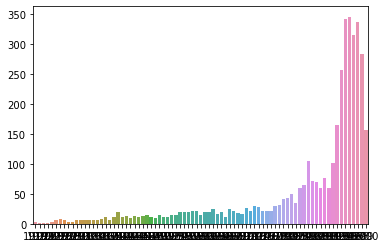

In [52]:
rel_li = movie_df['released_year_area'].value_counts().sort_index()
sns.barplot(rel_li.index, rel_li.values)
plt.show()

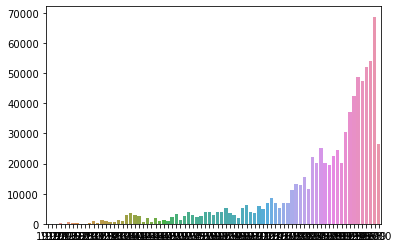

In [53]:
rel_li = train_df['released_year_area'].value_counts().sort_index()
sns.barplot(rel_li.index, rel_li.values)
plt.show()

    - 분포가 같으므로 그대로 진행
   

<AxesSubplot:>

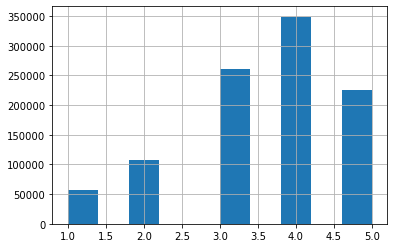

In [54]:
rating_df['rating'].hist()

<AxesSubplot:>

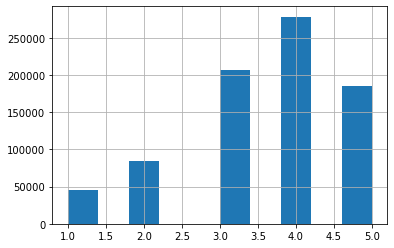

In [55]:
train_df['rating'].hist()

    - 분포가 같으므로 그대로 진행

### 문제 17. Feature Mapping - Profiling 피처맵 맵핑

In [56]:
# profile 완료된 경과로 피처맵 맵핑

train_df = train_df[['user_id', 'movie_id', 'rating', 'released_year_area', 
                     'main_genre','gender', 'occupation', 'age_bucket']]

train_df['released_year_area'] = train_df['released_year_area'].map(year_dict)
train_df['main_genre'] = train_df['main_genre'].map(genre_dict)
train_df['gender'] = train_df['gender'].map(gender_index)
train_df['occupation'] = train_df['occupation'].map(occupation_index)
train_df['age_bucket'] = train_df['age_bucket'].map(age_index)

train_df.head()
# ex.
# 	user_id	movie_id	rating	released_year_area	main_genre	gender	occupation	age_bucket
# 0	635	1251	4	4	5	2	9	2
# 1	635	3948	4	10	3	2	9	2
# 2	635	1270	4	3	3	2	9	2
# 3	635	1279	5	1	3	2	9	2
# 4	635	1286	4	3	5	2	9	2

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,635,1251,4,32,5,2,9,2
1,635,3948,4,79,3,2,9,2
2,635,1270,4,66,3,2,9,2
3,635,1279,5,15,3,2,9,2
4,635,1286,4,28,5,2,9,2


In [57]:
test_df = pd.merge(test_df, movie_df, on='movie_id')
test_df = pd.merge(test_df, user_df, on='user_id')
test_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1975,Drama,F,1,10,48067,outlier
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,1996,Animation,F,1,10,48067,outlier
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,1964,Musical,F,1,10,48067,outlier
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,2000,Drama,F,1,10,48067,outlier
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,Animation,F,1,10,48067,outlier


In [58]:
test_df = test_df[['user_id', 'movie_id', 'rating', 'released_year_area', 
                     'main_genre','gender', 'occupation', 'age_bucket']]

test_df['released_year_area'] = test_df['released_year_area'].map(year_dict)
test_df['main_genre'] = test_df['main_genre'].map(genre_dict)
test_df['gender'] = test_df['gender'].map(gender_index)
test_df['occupation'] = test_df['occupation'].map(occupation_index)
test_df['age_bucket'] = test_df['age_bucket'].map(age_index)
test_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,1,1193,5,29,5,1,1,1
1,1,661,3,3,1,1,1,1
2,1,914,3,9,18,1,1,1
3,1,3408,4,79,5,1,1,1
4,1,2355,5,39,1,1,1,1


### 문제 18. Binary Transformation - 평가 점수 기준으로 (0,1) 변환

In [60]:
# rating이 4점 이상인 경우 1, 3점 이하인 경우 0으로 변환
import numpy as np

train_df['y'] = np.where(train_df['rating'] >= 4, 1, 0)
test_df['y'] = np.where(test_df['rating'] >= 4, 1, 0)

### 문제 19. Feature Vector 생성 - libsvm 포맷의 데이터셋 생성


#### Sparse Vector in Linear Model

    [Sparse Vector]
    1. 0, 1로 값을 표현하는 벡터가 매우 희소한 상황
    2. 아래 그림에서 3002개의 벡터 중, 1이 등장하는 벡터는 단 두개
    3. Linear Model에서 Sparse 하다는 것은 이러한 상황을 의미

![sparse](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/sparse.png)

----

    [Linear Model]
    1. 입력 특성에 대한 선형 함수를 만들어 예측을 수행하는 모델
    2. y = a1x1 + a2x2... 같은 방정식이라고 생각할 수 있음
    3. 일반적인 랭킹 모델은 Linear Model로 마지막 추론을 하게 되어있음
    4. x1, x2...가 바로 Sparse Vector를 의미함

----

    [libsvm 포맷]
    1. "index":"value" 형태로 sparse vector를 표현하는 형태
    2. 위 그림을 표현하면, "1:1 3001:1" 이 됨.

In [61]:
train_df.columns

Index(['user_id', 'movie_id', 'rating', 'released_year_area', 'main_genre',
       'gender', 'occupation', 'age_bucket', 'y'],
      dtype='object')

In [62]:
train_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket,y
0,635,1251,4,32,5,2,9,2,1
1,635,3948,4,79,3,2,9,2,1
2,635,1270,4,66,3,2,9,2,1
3,635,1279,5,15,3,2,9,2,1
4,635,1286,4,28,5,2,9,2,1


In [63]:
col_len_dict = {
    'user_id' : len(train_df['user_id'].unique()),
    'movie_id' : len(train_df['movie_id'].unique()),
    'released_year_area' : len(train_df['released_year_area'].unique()),
    'main_genre' : len(train_df['main_genre'].unique()),
    'gender' : len(train_df['gender'].unique()),
    'occupation' : len(train_df['occupation'].unique()),
    'age_bucket' : len(train_df['age_bucket'].unique())
}

col_accum_index_dict = {} # 누적값 key value 만든 dict
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

In [64]:
col_len_dict

{'user_id': 5400,
 'movie_id': 3662,
 'released_year_area': 81,
 'main_genre': 18,
 'gender': 2,
 'occupation': 21,
 'age_bucket': 6}

In [65]:
col_accum_index_dict

{'user_id': 0,
 'movie_id': 5400,
 'released_year_area': 9062,
 'main_genre': 9143,
 'gender': 9161,
 'occupation': 9163,
 'age_bucket': 9184}

In [66]:
for idx, row in train_df.iterrows():
    vec = []
    label = row['y']
    vec.append(str(label))
    row = row.drop(labels=['rating', 'y'])
    
    for key, value in row.items():
        col_idx = col_accum_index_dict[key] + value - 1
        vec.append(str(col_idx) + ':' + str(1))

In [67]:
# libsvm 포맷의 데이터셋 생성

vec

['1', '3325:1', '9218:1', '9124:1', '9145:1', '9162:1', '9166:1', '9187:1']

In [68]:
# ex. 1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1

## Step 4. 추천 랭킹 모델링 (Factorization Machine)

#### Factorization Machine

![equation](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbRP7gn%2FbtqDw3LQxDB%2FXmWK8heUckUWpHx379UCM1%2Fimg.png)

    [랭킹 모델의 형태와 역할]
    1. Linear Regression, SVM처럼 동작하는 General predictor
    2. 변수 간의 모든 pair-wise interaction을 계산하는 알고리즘
    3. General predictor의 장점 + MF 알고리즘이 가지는 의미 단위 해석(latent factor)의 장점
    4. sparse한 데이터셋을 가지고 있을 때 적합

### 문제 20. 학습 데이터 생성 - 특정 시간 기준 Train/Test 데이터셋 생성

In [ ]:
# !pip install xlearn

In [ ]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [ ]:
txt_file = open('test.txt', 'w')
for idx, row in test_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [ ]:
# import xlearn as xl

# ffm_model = xl.create_ffm()
# ffm_model.setSigmoid()
# param = {'task' : 'binary', 'lr' : 0.05, 'lambda' : 0.002, 'epoch' : 30,
#         'stop_window' : 3, 'nthread' : -1}
# ffm_model.setTrain('./train.txt')
# ffm_model.setTest('./test.txt')

# ffm_model.fit(param, './ffm_model.out')

### 문제 21. 모델링 - FM Binary Classification 모델 학습

In [69]:
import numpy as np
from sklearn.metrics import roc_auc_score


class FactorizationMachine():
    """
    This Class is implementation of this paper : https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf
    Just a example of FM Algorithm, not for production.
    -----
    Only simple methods are available.
    e.g 1 : batch training, adagrad optimizer, parallel training are not supported.
    e.g 2 : simple optimizer Stochastic Gradient Descent with L2 Regularization.
    e.g 3 : using titanic dataset on local memory.
    """
    def __init__(self, k, lr, l2_reg, l2_lambda, epoch, early_stop_window, train_data, valid_data):
        """
        :param k: number of latent vector
        :param lr: learning rate
        :param l2_reg: bool parameter for L2 regularization
        :param l2_lambda: lambda of L2 regularization
        :param epoch: training epoch
        :param train_data: path of train data
        :param valid_data: path of valid data
        """
        self._k = k
        self._lr = lr
        self._l2_reg = l2_reg
        self._l2_lambda = l2_lambda
        self._epoch = epoch
        self._early_stop_window = early_stop_window
        self._train_file_path = train_data
        self._valid_file_path = valid_data
        self._valid_loss_list = []

    def _load_dataset(self):
        """
        1. load dataset to memory from train/valid path
        2. find max index in dataset for w's vector size
        """
        # load data
        train_file = open(self._train_file_path, 'r')
        valid_file = open(self._valid_file_path, 'r')
        self._train_data = train_file.read().split('\n')
        self._valid_data = valid_file.read().split('\n')
        train_file.close()
        valid_file.close()

        # find max index
        self.feature_max_index = 0
        print("Start to init FM vectors.")
        for row in self._train_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        for row in self._valid_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        # init FM vectors
        self._init_vectors()
        print("Finish init FM vectors.")

    def _init_vectors(self):
        """
        1. initialize FM vectors
        2. Conduct naive transformation libsvm format txt data to numpy training sample.
        """
        self.w = np.random.randn(self.feature_max_index+1)
        self.v = np.random.randn(self.feature_max_index+1, self._k)
        self.train_x_data = []
        self.train_y_data = np.zeros((len(self._train_data)-1))
        self.valid_x_data = []
        self.valid_y_data = np.zeros((len(self._valid_data)-1))

        # make numpy dataset
        for n, row in enumerate(self._train_data):
            element = row.split(" ")
            if len(element) > 1:
              self.train_y_data[n] = int(element[0])
              self.train_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

        for n, row in enumerate(self._valid_data):
            element = row.split(" ")
            if len(element) > 1:
              self.valid_y_data[n] = int(element[0])
              self.valid_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

    def train(self):
        """
        Train FM model by Gradient Descent with L2 regularization
        """
        self._load_dataset()
        for epoch_num in range(1, self._epoch):
            train_y_hat = self.predict(data=self.train_x_data)
            valid_y_hat = self.predict(data=self.valid_x_data)
            train_loss = self._get_loss(y_data=self.train_y_data, y_hat=train_y_hat)
            valid_loss = self._get_loss(y_data=self.valid_y_data, y_hat=valid_y_hat)
            train_auc = roc_auc_score(self.train_y_data, train_y_hat)
            valid_auc = roc_auc_score(self.valid_y_data, valid_y_hat)
            self._print_learning_info(epoch=epoch_num, train_loss=train_loss, valid_loss=valid_loss,
                                      train_auc=train_auc, valid_auc=valid_auc)
            if self._check_early_stop(valid_loss=valid_loss):
                print("Early stop at epoch:", epoch_num)
                return 0

            self._stochastic_gradient_descent(self.train_x_data, self.train_y_data)

    def predict(self, data):
        """
        Implementation of FM model's equation on O(kmd)
        -----
        Numpy array shape : (n, [index of md], [value of md])
        md : none-zero feature
        """
        num_data = len(data)
        scores = np.zeros(num_data)
        for n in range(num_data):
            feat_idx = data[n][0]
            val = data[n][1]

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            scores[n] = linear_feature_score + cross_feature_score

        # Sigmoid transformation for binary classification
        scores = 1.0 / (1.0 + np.exp(-scores))
        return scores

    def _get_loss(self, y_data, y_hat):
        """
        Calculate loss with L2 regularization (two type of coeficient - w,v)
        """
        l2_norm = 0
        if self._l2_reg:
            w_norm = np.sqrt(np.sum(np.square(self.w)))
            v_norm = np.sqrt(np.sum(np.square(self.v)))
            l2_norm = self._l2_lambda * (w_norm + v_norm)
        return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm

    def _check_early_stop(self, valid_loss):
        self._valid_loss_list.append(valid_loss)
        if len(self._valid_loss_list) > 5:
            prev_loss = self._valid_loss_list[len(self._valid_loss_list) - self._early_stop_window]
            curr_loss = valid_loss
            if prev_loss < curr_loss:
                return True
        return False

    def _print_learning_info(self, epoch, train_loss, valid_loss, train_auc, valid_auc):
        print("epoch:", epoch, "||", "train_loss:", train_loss, "||", "valid_loss:", valid_loss,
              "||", "Train AUC:", train_auc, "||", "Test AUC:", valid_auc)


    def _stochastic_gradient_descent(self, x_data, y_data):
        """
        Update each coefs (w, v) by Gradient Descent
        """
        for data, y in zip(x_data, y_data):
            feat_idx = data[0]
            val = data[1]
            vx = self.v[feat_idx] * (val.reshape(-1, 1))

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            score = linear_feature_score + cross_feature_score
            y_hat = 1.0 / (1.0 + np.exp(-score))
            cost = y_hat - y

            if self._l2_reg:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * (val + self._l2_lambda * self.w[feat_idx])
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * ((sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1)))) + self._l2_lambda * self.v[feat_idx])
            else:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * val
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * (sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1))))

### 문제 22. 모델링 - AUC 평가

In [70]:
fm = FactorizationMachine(k=4,
                          lr=0.01,
                          l2_reg=True,
                          l2_lambda=0.0002,
                          epoch=30,
                          early_stop_window=3,
                          train_data='./train.txt',
                          valid_data='./test.txt')
fm.train()

Start to init FM vectors.
Finish init FM vectors.
epoch: 1 || train_loss: nan || valid_loss: nan || Train AUC: 0.49682141489023673 || Test AUC: 0.4920327405434935
epoch: 2 || train_loss: 683971.0913041441 || valid_loss: 187548.29637664554 || Train AUC: 0.6063013773815193 || Test AUC: 0.5777114278586057
epoch: 3 || train_loss: 611770.7800235209 || valid_loss: 172557.09264991555 || Train AUC: 0.6428889749982716 || Test AUC: 0.6002134081285855
epoch: 4 || train_loss: 575537.0268286272 || valid_loss: 165192.7633140344 || Train AUC: 0.6653509638447862 || Test AUC: 0.6136070422109838
epoch: 5 || train_loss: 552470.4250369353 || valid_loss: 160585.82627528312 || Train AUC: 0.681517778883576 || Test AUC: 0.6230623104428648
epoch: 6 || train_loss: 535998.6433546772 || valid_loss: 157350.88998843127 || Train AUC: 0.6940060135289824 || Test AUC: 0.6303119137940224
epoch: 7 || train_loss: 523527.4122431569 || valid_loss: 154932.70844378814 || Train AUC: 0.7039756775866056 || Test AUC: 0.6361065045

0

## Step 5. 모의 추천 시스템 구축

### 문제 23. 추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

In [78]:
# train 데이터셋에서 유저 시청 목록 추출

q_8 # quantile 0.8 of Dataset

def get_movie_list_sort_by_time(x):
    return x.sort_values(['time'])['movie_id'].tolist()

train_user_watch_list = rating_df[rating_df['time'] < q_8].groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_by_time(x))
train_user_watch_list

user_id
635     [2294, 480, 920, 3614, 1270, 1286, 3528, 3948,...
636     [2123, 1721, 110, 1210, 2193, 1197, 2746, 3693...
637     [908, 1376, 2792, 2085, 1203, 924, 1019, 965, ...
638     [1210, 1978, 2716, 2617, 788, 2555, 2532, 3555...
639     [2028, 2944, 1961, 1363, 2634, 1198, 2571, 589...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 2019, 1961, 573, 3111, 3505, ...
Length: 5400, dtype: object

### 문제 24. 추천 결과 평가 - Train 데이터 기반 유저별 추천 후보군 생성

#### 1) 최근 시청한 3개 영화의 연관 영화 목록 추출

In [79]:
# train 데이터셋으로만 m2v 모델 학습
w2v_train_df = pd.merge(rating_df[rating_df['time'] < q_8], movie_df, on='movie_id')
w2v_train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre
0,635,1251,4,975768620,8 1/2 (1963),Drama,1963,Drama
1,673,1251,5,975623211,8 1/2 (1963),Drama,1963,Drama
2,711,1251,5,975621446,8 1/2 (1963),Drama,1963,Drama
3,737,1251,5,975481404,8 1/2 (1963),Drama,1963,Drama
4,829,1251,5,975369343,8 1/2 (1963),Drama,1963,Drama


In [86]:
from gensim.models import Word2Vec



m2v_model = Word2Vec.load('./movie2vec_model')

In [92]:
m2v_model.wv.most_similar('movie_id:1251')

[('movie_id:2731', 0.7077617049217224),
 ('movie_id:3467', 0.69098961353302),
 ('movie_id:3416', 0.6475498080253601),
 ('movie_id:1511', 0.6274399757385254),
 ('movie_id:965', 0.6214653253555298),
 ('movie_id:1952', 0.6186220049858093),
 ('movie_id:2732', 0.61729896068573),
 ('movie_id:872', 0.6172923445701599),
 ('movie_id:2925', 0.6146974563598633),
 ('movie_id:1262', 0.6133973002433777)]

In [98]:
# model = Word2Vec(movie2vec_dataset,
#                  size=100,
#                  window=6,  # 주변 word의 윈도우
#                  sg=1,  # skip-gram OR cbow
#                  hs=0,  # hierarchical softmax OR negative sampling
#                  negative=20,  # negative sampling 파라미터
#                  min_count=1,  # word의 등장 최소 횟수
#                  iter=20)

In [100]:
def get_recent_movie_list_sort_by_time(x, k):
    return x.sort_values(['time'])['movie_id'].tolist()[-k:]

In [102]:
# 유저별 최근 시청한 3개 영화 추출
recent_user_watch_list = rating_df[rating_df['time'] < 975768738].groupby('user_id')[['movie_id', 'time']].apply(lambda x : get_recent_movie_list_sort_by_time(x, 3))
recent_user_watch_list

user_id
635     [1884, 2966, 3198]
636     [1391, 1690, 3156]
637     [1378, 1278, 1379]
638     [1587, 2193, 3863]
639     [2762, 3114, 2987]
               ...        
6036    [1862, 2807, 3574]
6037      [2641, 968, 435]
6038    [1419, 2700, 1183]
6039     [1204, 922, 1254]
6040    [3751, 1077, 3168]
Length: 5400, dtype: object

In [116]:
item2item = {}

# 영화별 연관 영화 (item2item) k개씩 추출

k = 10
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
    item2item[movie_id] = []
    try:
        sim_list = model.wv.most_similar('movie_id:' + str(movie_id), topn=k+10)
        for movie_tup in sim_list:
            tup_info = movie_tup[0].split(':')
            if (tup_info[0] == 'movie_id') and (len(item2item[movie_id]) < 10):
                item2item[movie_id].append(tup_info[1])
    except:
        not_in_count += 1
        print('word', str(movie_id), 'not in vocabulary')

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [121]:
movie_df.columns

Index(['movie_id', 'title', 'genre', 'released_year_area', 'main_genre'], dtype='object')

In [136]:
def i2i_movie_titles(movie_idx):
    rec_list = item2item[movie_idx]
    print('영화 : ',movie_df[movie_df['movie_id'] == movie_idx]['title'].values)
    rec_list_title = []
    for rec in rec_list:
        rec_list_title.append(movie_df[movie_df['movie_id'] == int(rec)]['title'].values[0])
    print('추천 영화')
    return rec_list_title

i2i_movie_titles(1)

영화 :  ['Toy Story (1995)']
추천 영화


['Grand Day Out, A (1992)',
 'Close Shave, A (1995)',
 'Babe (1995)',
 'Toy Story 2 (1999)',
 'Creature Comforts (1990)',
 'Groundhog Day (1993)',
 'Wrong Trousers, The (1993)',
 'Living in Oblivion (1995)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Shall We Dance? (Shall We Dansu?) (1996)']

In [137]:
i2i_movie_titles(3156)

영화 :  ['Bicentennial Man (1999)']
추천 영화


['What Planet Are You From? (2000)',
 'Play it to the Bone (1999)',
 'Deuce Bigalow: Male Gigolo (1999)',
 'Mystery, Alaska (1999)',
 'Junior (1994)',
 'My Favorite Martian (1999)',
 'Drowning Mona (2000)',
 'Crazy in Alabama (1999)',
 'Hanging Up (2000)',
 'Coneheads (1993)']

In [138]:
def get_similar_items(x, k):
    similar_items = []
    for movie_id in x:
        similar_items.append(item2item[movie_id][:k])
    return [item for items in similar_items for item in items]

recent_watch_similar_items = recent_user_watch_list.apply(lambda x: get_similar_items(x, 5))

In [141]:
recent_user_watch_list

user_id
635     [1884, 2966, 3198]
636     [1391, 1690, 3156]
637     [1378, 1278, 1379]
638     [1587, 2193, 3863]
639     [2762, 3114, 2987]
               ...        
6036    [1862, 2807, 3574]
6037      [2641, 968, 435]
6038    [1419, 2700, 1183]
6039     [1204, 922, 1254]
6040    [3751, 1077, 3168]
Length: 5400, dtype: object

In [151]:
recent_watch_similar_items # 최대 15개 까지 추천

user_id
635     [2155, 1895, 1476, 372, 2765, 3006, 3163, 3083...
636     [780, 442, 379, 2393, 1676, 1320, 1762, 2525, ...
637     [368, 1379, 3444, 303, 2478, 1136, 1080, 1997,...
638     [2403, 2376, 2370, 2990, 3197, 2161, 2005, 196...
639     [2840, 3006, 2841, 2692, 3147, 2700, 1, 1148, ...
                              ...                        
6036    [2448, 3665, 3572, 519, 3663, 692, 546, 2549, ...
6037    [1375, 2105, 3698, 2613, 3704, 2901, 2553, 245...
6038    [3152, 3201, 1964, 3093, 3359, 2395, 3114, 1, ...
6039    [1262, 1254, 1207, 1178, 919, 1267, 3435, 1252...
6040    [3615, 3481, 3618, 3536, 3785, 1234, 3200, 336...
Length: 5400, dtype: object

#### 2) 평점 기반 인기 영화

In [156]:
mean_ratings = rating_df[rating_df['time'] < q_8].groupby('movie_id')['rating'].agg(['mean', 'count'])
mean_ratings

,mean,count
movie_id,,
1,4.145714,1750
2,3.197880,566
3,3.023560,382
4,2.701493,134
5,2.995781,237
...,...,...
3948,3.720621,451
3949,4.328947,76
3950,3.133333,15


In [158]:
# 평점 높은 상위 10개의 영화 추출 ( count 100 이상 )
popular_movie_list = mean_ratings[mean_ratings['count'] > 100]['mean'].sort_values(ascending=False).index[:10].tolist()
popular_movie_list

[2019, 318, 922, 745, 50, 858, 1148, 527, 1178, 904]

#### 3) 장르, 연도별 인기 영화

In [161]:
merge_df = pd.merge(mean_ratings, movie_df, on='movie_id')
merge_df.head()

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.145714,1750,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
1,2,3.197880,566,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
2,3,3.023560,382,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
3,4,2.701493,134,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
4,5,2.995781,237,Father of the Bride Part II (1995),Comedy,1995,Comedy


In [172]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화 리스트 추출

def get_meta_popular_list(x, k):
    movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
    return movie_id_list[:k]
    
genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
print(genre_popular)
print()
year_popular = merge_df.groupby('released_year_area').apply(lambda x: get_meta_popular_list(x, k=10))
print(year_popular)

main_genre
Action         [2905, 2019, 858, 1198, 260, 1221, 2028, 2571,...
Adventure      [3172, 1204, 1262, 1254, 919, 3470, 1303, 1259...
Animation      [745, 1148, 720, 3429, 1223, 3114, 1, 741, 281...
Children's     [1026, 1097, 1028, 34, 262, 3396, 3397, 531, 9...
Comedy         [3233, 3607, 1830, 3232, 2444, 3030, 3307, 341...
Crime          [3656, 50, 3517, 3435, 1260, 296, 1213, 608, 1...
Documentary    [3881, 787, 2930, 1149, 3338, 1147, 3679, 128,...
Drama          [989, 3522, 2964, 1471, 3382, 53, 1664, 2503, ...
Fantasy                                              [792, 2021]
Film-Noir      [922, 913, 1267, 1252, 2186, 930, 541, 2203, 1...
Horror         [1219, 1258, 1997, 1348, 2648, 1340, 2664, 133...
Musical        [899, 914, 1947, 3606, 2565, 3545, 1035, 900, ...
Mystery        [904, 1212, 903, 950, 906, 1086, 2206, 931, 16...
Romance        [928, 28, 932, 2721, 2708, 803, 1684, 1770, 29...
Sci-Fi         [750, 1206, 1199, 2010, 2660, 1301, 1921, 3658...
Thriller      

#### 4) 4개 추천 후보군 병합

##### 유저별 선호 장르/연도 파악

In [179]:
movie_dict = merge_df[['movie_id', 'released_year_area', 'main_genre']].to_dict()

In [177]:
from collections import Counter 

def most_frequent(x): 
    occurence_count = Counter(x) 
    return occurence_count.most_common(1)[0][0] 

def get_items_by_prefer_meta(x):
  year_list = []
  genre_list = []
  for movie_id in x:
    if movie_id in movie_dict['released_year_area']:
      year_list.append(movie_dict['released_year_area'][movie_id])
    if movie_id in movie_dict['main_genre']:
      genre_list.append(movie_dict['main_genre'][movie_id])
  prefer_year = most_frequent(year_list)
  prefer_genre = most_frequent(genre_list)
  return year_popular[prefer_year] + genre_popular[prefer_genre]

items_by_prefer_meta = train_user_watch_list.apply(lambda x: get_items_by_prefer_meta(x))


In [180]:
train_user_watch_list

user_id
635     [2294, 480, 920, 3614, 1270, 1286, 3528, 3948,...
636     [2123, 1721, 110, 1210, 2193, 1197, 2746, 3693...
637     [908, 1376, 2792, 2085, 1203, 924, 1019, 965, ...
638     [1210, 1978, 2716, 2617, 788, 2555, 2532, 3555...
639     [2028, 2944, 1961, 1363, 2634, 1198, 2571, 589...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 2019, 1961, 573, 3111, 3505, ...
Length: 5400, dtype: object

##### 최종 병합

In [183]:
merged_candidates = recent_watch_similar_items + items_by_prefer_meta
recommendations = merged_candidates.apply(lambda x: set(x))
recommendations

user_id
635     {1664, 3163, 3194, 1955, 1423, 527, 2964, 2330...
636     {1664, 3146, 1320, 2393, 2444, 527, 2324, 2964...
637     {1664, 1423, 527, 2964, 1379, 2330, 1080, 3444...
638     {2692, 2309, 2005, 2444, 3607, 2329, 3232, 323...
639     {1664, 1, 2692, 2309, 2070, 527, 2964, 2329, 2...
                              ...                        
6036    {1664, 1105, 3663, 3572, 1423, 527, 2964, 2330...
6037    {1664, 2553, 3698, 1391, 1423, 527, 2964, 2330...
6038    {1664, 1, 3152, 1964, 3359, 1423, 527, 2964, 2...
6039    {1664, 1931, 1252, 1423, 527, 2964, 1204, 1207...
6040    {3011, 1664, 1423, 527, 3618, 2964, 3461, 2330...
Length: 5400, dtype: object

### 문제 25. 추천 결과 평가 - 랭킹 모델로 추천 후보군 K개 정렬

#### predict 가능한 포맷으로 변경
- ex) [[array([31, 55, 66, 77]), array([1, 1, 1, 1])]]

In [185]:
movie_df['released_year_area'] = movie_df['released_year_area'].apply(lambda x: year_dict[x])
movie_df['main_genre'] = movie_df['main_genre'].apply(lambda x: genre_dict[x])
movie_df = movie_df[['movie_id', 'released_year_area', 'main_genre']]
movie_df.head()

,movie_id,released_year_area,main_genre
0,1,1,1
1,2,1,2
2,3,1,3
3,4,1,3
4,5,1,3


In [186]:
user_df['gender'] = user_df['gender'].apply(lambda x: gender_index[x])
user_df['occupation'] = user_df['occupation'].apply(lambda x: occupation_index[x])
user_df['age_bucket'] = user_df['age_bucket'].apply(lambda x: age_index[x])
user_df = user_df[['user_id', 'gender', 'age_bucket', 'occupation']]
user_df.head()

,user_id,gender,age_bucket,occupation
0,1,1,1,1
1,2,2,2,2
2,3,2,3,3
3,4,2,4,4
4,5,2,3,5


In [191]:
movie_index_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()
str(movie_index_dict)[:300]

"{'released_year_area': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1"

In [192]:
user_index_dict = user_df.set_index('user_id')[['gender', 'age_bucket', 'occupation']].to_dict()
str(user_index_dict)[:300]

"{'gender': {1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 2, 10: 1, 11: 1, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 2, 18: 1, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 1, 25: 2, 26: 2, 27: 2, 28: 1, 29: 2, 30: 1, 31: 2, 32: 1, 33: 2, 34: 1, 35: 2, 36: 2, 37: 1, 38: 1, 39: 2, 40: 2, 41: 1, 42: 2, 43:"

In [193]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [194]:
col_accum_index_dict

{'user_id': 0,
 'movie_id': 5400,
 'released_year_area': 9062,
 'main_genre': 9143,
 'gender': 9161,
 'occupation': 9163,
 'age_bucket': 9184}

In [195]:
def make_libsvm_row(uid, mid):
  row = []
  user_id = str(col_accum_index_dict['user_id'] + uid - 1) + ":" + str(1)
  gender = str(col_accum_index_dict['gender'] + user_index_dict['gender'][uid] - 1) + ":" + str(1)
  age_bucket = str(col_accum_index_dict['age_bucket'] + user_index_dict['age_bucket'][uid] - 1) + ":" + str(1)
  occupation = str(col_accum_index_dict['occupation'] + user_index_dict['occupation'][uid] - 1) + ":" + str(1)
  movie_id = str(col_accum_index_dict['movie_id'] + int(mid) - 1) + ":" + str(1)
  released_year_area = str(col_accum_index_dict['released_year_area'] + movie_index_dict['released_year_area'][int(mid)] - 1) + ":" + str(1)
  main_genre = str(col_accum_index_dict['main_genre'] + movie_index_dict['main_genre'][int(mid)] - 1) + ":" + str(1)
  return " ".join([user_id, gender, age_bucket, occupation, movie_id, released_year_area, main_genre])

# make vector list
vector_list = []
uid_mid_list = []
for uid, movie_set in recommendations.iteritems():
  for mid in movie_set:
    x_feature = []
    libsvm_row = make_libsvm_row(uid, mid)
    element = libsvm_row.split(" ")
    vector_list.append([np.array([int(pair.split(":")[0]) for pair in element]), np.array([int(pair.split(":")[1]) for pair in element])])
    uid_mid_list.append((uid, mid))

In [198]:
vector_list[0]

[array([ 634, 9162, 9185, 9171, 7063, 9064, 9147]),
 array([1, 1, 1, 1, 1, 1, 1])]

In [199]:
uid_mid_list[0]

(635, 1664)

In [200]:
predict_results = fm.predict(vector_list)
predict_results

array([0.43301227, 0.97068501, 0.96086514, ..., 0.82627949, 0.32090598,
       0.86852264])

#### 후보군 정렬

In [201]:
# 유저별 추천 후보군 재정렬
# ex. 
# {635: {1664: 0.49089334810703084, 3498: 0.7017178066091346, 2444: 0.3960630484760756...}, ...}
# -> {userid: {movieid: score...}...}

user_recommendation_dict = {}
for watch_prob, uid_mid in zip(predict_results, uid_mid_list):
  uid, mid = int(uid_mid[0]), int(uid_mid[1])
  if uid not in user_recommendation_dict:
    user_recommendation_dict[uid] = {}
    user_recommendation_dict[uid][mid] = watch_prob
  else:
    if mid not in user_recommendation_dict[uid]:
      user_recommendation_dict[uid][mid] = watch_prob

In [202]:
str(user_recommendation_dict)[:2000]

'{635: {1664: 0.4330122686514756, 3163: 0.97068500524726, 3194: 0.9608651380632204, 1955: 0.946580528577798, 1423: 0.9354239269179316, 527: 0.9944633815641114, 2964: 0.973483389937908, 2330: 0.9787207495328553, 3733: 0.9777151442411401, 3006: 0.9886410427437993, 3135: 0.9568415619889458, 2609: 0.9413149895192962, 53: 0.9967836944256572, 3382: 0.9625909794457652, 2765: 0.17044943551974803, 318: 0.9980207652826459, 1471: 0.5588708555780335, 1476: 0.8878042588067493, 3522: 0.9998066836826133, 2503: 0.9806662889260139, 372: 0.9844393072301256, 1358: 0.9810827235777135, 720: 0.9424632341572386, 2501: 0.9895031865452202, 3083: 0.9869833177243922, 1117: 0.9523989631189118, 2682: 0.9698405682931681, 989: 0.8012763327801787, 608: 0.9905653117711244, 1895: 0.9497125942717543, 2155: 0.8652427663456409, 1002: 0.9972259655216604, 3498: 0.9825665379836297, 1147: 0.9742212368993244}, 636: {1664: 0.9387038554326855, 3146: 0.3792738812079292, 1320: 0.45494842230511207, 2393: 0.48276045790430944, 2444: 

## Step 6. 추천 결과 평가

### 문제 26. 추천 결과 평가 - 추천 후보군과 Test 데이터간의 MAP@K 계산

In [203]:
# 4점 이상을 준 test 시청리스트 추출
user_actual_watch_list = rating_df[(rating_df['time'] < 975768738) & (rating_df['rating'] >= 4)].groupby('user_id')['movie_id'].apply(lambda x: x.tolist())
user_actual_watch_list

user_id
635     [1251, 3948, 1270, 1279, 1286, 3035, 920, 3067...
636     [2054, 589, 1261, 780, 968, 2455, 1653, 2460, ...
637     [2987, 3930, 3932, 3791, 1250, 2054, 1252, 125...
638     [2987, 3793, 1259, 592, 1270, 1275, 1285, 3039...
639     [2058, 589, 1408, 733, 592, 1275, 913, 3062, 1...
                              ...                        
6036    [589, 3006, 3008, 2064, 2069, 590, 593, 594, 5...
6037    [3006, 2064, 593, 903, 904, 908, 909, 910, 912...
6038    [1419, 3088, 232, 1136, 1148, 1183, 2146, 3548...
6039    [588, 2067, 1416, 3022, 2080, 3035, 3037, 901,...
6040    [573, 589, 593, 2070, 2076, 903, 904, 908, 910...
Name: movie_id, Length: 5396, dtype: object

In [204]:
estimated_list = user_recommendation_dict[635].copy()
sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
top_k_list = [tup[0] for tup in sorted_list][:10]

In [211]:
top_k_list

[318, 1085, 3382]

In [205]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in user_recommendation_dict:
  try:
    estimated_list = user_recommendation_dict[user].copy()
    sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
    top_k_list = [tup[0] for tup in sorted_list][:k]
    user_metric.append((user, top_k_list, user_actual_watch_list[user]))
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486


In [206]:
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [207]:
get_map(user_metric)

0.09655300222386852

In [208]:
def get_map_topk(k):
  user_metric = []
  for user in user_recommendation_dict:
    try:
      estimated_list = user_recommendation_dict[user].copy()
      sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
      top_k_list = [tup[0] for tup in sorted_list][:k]
      user_metric.append((user, top_k_list, user_actual_watch_list[user]))
    except:
      print("list index out of range, exclude user " + str(user))
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [209]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index 

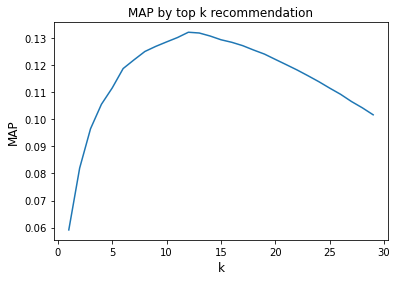

In [210]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()